<a href="https://colab.research.google.com/github/BilalKhaliqWillis/BILAL-Assignment2/blob/main/BILAL_Assignment6AMCO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
# Advanced Model Compression and Optimization — CIFAR-10

# This notebook implements a full pipeline for the assignment:-
# - Baseline CNN training on CIFAR-10 (PyTorch)
# - Measurement of model size and inference latency
# - Two compression techniques:- structured/unstructured pruning and post-training quantization
# - Evaluation and visualizations of training curves, confusion matrix
#
# Imports
import os, time, copy
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
import torchvision
import torchvision.transforms as T
from torchvision.datasets import CIFAR10

# pruning utils
import torch.nn.utils.prune as prune

# for confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [45]:
# Configuration
CFG = {
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "batch_size": 128,
    "num_epochs": 10,   # fast by default
    "learning_rate": 0.01,
    "momentum": 0.9,
    "weight_decay": 5e-4,
    "save_dir": "./outputs",
    "seed": 42,
}
os.makedirs(CFG["save_dir"], exist_ok=True)

torch.manual_seed(CFG["seed"])
np.random.seed(CFG["seed"])


In [46]:
# Augmentation for CIFAR-10
transform_train = T.Compose([
    T.RandomCrop(32, padding=4),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
])
transform_test = T.Compose([
    T.ToTensor(),
    T.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
])

# Download datasets
trainset = CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# sub-sample for faster runs
# small_train_idx = np.random.choice(len(trainset), size=int(len(trainset)*0.5), replace=False)
# trainset = Subset(trainset, small_train_idx)

trainloader = DataLoader(trainset, batch_size=CFG['batch_size'], shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=CFG['batch_size'], shuffle=False, num_workers=2)

classes = trainset.classes
print("Classes:", classes)


Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [49]:
# SmallCNN model
class SmallCNN(nn.Module):
    # Fast CNN for CIFAR-10
    def __init__(self, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 32 -> 16

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 16 -> 8

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 8 -> 4
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*4*4, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# quick sanity
model = SmallCNN().to(CFG['device'])
print(model)


SmallCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2048, out_features=256, bias=True)
    (2): ReLU()
    (3): Dropout

In [51]:
# Training & evaluation utilities
def train_one_epoch(model, criterion, optimizer, dataloader, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, preds = outputs.max(1)
        correct += preds.eq(targets).sum().item()
        total += targets.size(0)
    return running_loss / total, correct / total

def evaluate(model, criterion, dataloader, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_loss += loss.item() * inputs.size(0)
            _, preds = outputs.max(1)
            correct += preds.eq(targets).sum().item()
            total += targets.size(0)
            all_preds.append(preds.cpu().numpy())
            all_targets.append(targets.cpu().numpy())
    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)
    return running_loss / total, correct / total, all_preds, all_targets

def model_size_mb(model, path='temp.pth'):
    torch.save(model.state_dict(), path)
    size_mb = os.path.getsize(path) / (1024 * 1024)
    os.remove(path)
    return size_mb

def measure_latency(model, device, input_size=(1,3,32,32), n_runs=100):
    model.eval()
    inputs = torch.randn(input_size).to(device)
    # warmup
    with torch.no_grad():
        for _ in range(10):
            _ = model(inputs)
    times = []
    with torch.no_grad():
        for _ in range(n_runs):
            start = time.time()
            _ = model(inputs)
            if device == 'cuda':
                torch.cuda.synchronize()
            end = time.time()
            times.append((end - start) * 1000)
    return float(np.mean(times)), float(np.std(times))


In [53]:
# Train baseline model
device = CFG['device']
model = SmallCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=CFG['learning_rate'], momentum=CFG['momentum'], weight_decay=CFG['weight_decay'])
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

train_history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

for epoch in range(CFG['num_epochs']):
    train_loss, train_acc = train_one_epoch(model, criterion, optimizer, trainloader, device)
    val_loss, val_acc, val_preds, val_targets = evaluate(model, criterion, testloader, device)
    scheduler.step()
    train_history['train_loss'].append(train_loss)
    train_history['train_acc'].append(train_acc)
    train_history['val_loss'].append(val_loss)
    train_history['val_acc'].append(val_acc)
    print(f"Epoch {epoch+1}/{CFG['num_epochs']} - train loss: {train_loss:.4f}, acc: {train_acc:.4f} | val loss: {val_loss:.4f}, acc: {val_acc:.4f}")

# Save baseline
baseline_path = os.path.join(CFG['save_dir'], 'baseline_smallcnn.pth')
torch.save(model.state_dict(), baseline_path)
print("Saved baseline to", baseline_path)


Epoch 1/10 - train loss: 1.5246, acc: 0.4383 | val loss: 1.1949, acc: 0.5646
Epoch 2/10 - train loss: 1.1832, acc: 0.5704 | val loss: 1.0087, acc: 0.6408
Epoch 3/10 - train loss: 1.0413, acc: 0.6293 | val loss: 0.8785, acc: 0.6968
Epoch 4/10 - train loss: 0.9420, acc: 0.6645 | val loss: 0.8701, acc: 0.6995
Epoch 5/10 - train loss: 0.8918, acc: 0.6841 | val loss: 0.7531, acc: 0.7331
Epoch 6/10 - train loss: 0.8355, acc: 0.7060 | val loss: 0.7318, acc: 0.7457
Epoch 7/10 - train loss: 0.7980, acc: 0.7188 | val loss: 0.7363, acc: 0.7401
Epoch 8/10 - train loss: 0.6850, acc: 0.7594 | val loss: 0.6074, acc: 0.7866
Epoch 9/10 - train loss: 0.6643, acc: 0.7668 | val loss: 0.6014, acc: 0.7870
Epoch 10/10 - train loss: 0.6488, acc: 0.7727 | val loss: 0.5987, acc: 0.7875
Saved baseline to ./outputs/baseline_smallcnn.pth


Baseline size: 2.38 MB  | Inference latency (mean): 1.69 ms (std 0.19 ms)
Baseline test accuracy: 0.7875


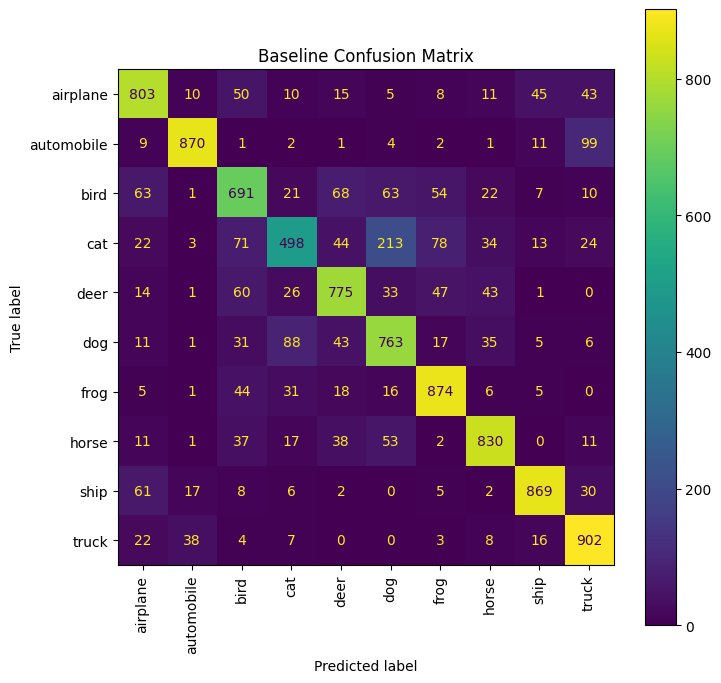

In [54]:
#Baseline metrics:- size, latency, confusion matrix
# Baseline model size & latency
baseline_size = model_size_mb(model, path=os.path.join(CFG['save_dir'],'_tmp_baseline.pth'))
lat_mean, lat_std = measure_latency(model, device, input_size=(1,3,32,32), n_runs=100)
print(f"Baseline size: {baseline_size:.2f} MB  | Inference latency (mean): {lat_mean:.2f} ms (std {lat_std:.2f} ms)")

# Confusion matrix
val_loss, val_acc, val_preds, val_targets = evaluate(model, criterion, testloader, device)
print("Baseline test accuracy:", val_acc)

cm = confusion_matrix(val_targets, val_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
fig, ax = plt.subplots(figsize=(8,8))
disp.plot(ax=ax, xticks_rotation='vertical')
plt.title('Baseline Confusion Matrix')
plt.show()

In [55]:
# Compression:- Global unstructured pruning (50%) + fine-tuning
# Copy baseline
pruned_model = copy.deepcopy(model)

# Select parameters to prune (conv & linear)
parameters_to_prune = []
for name, module in pruned_model.named_modules():
    if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
        parameters_to_prune.append((module, 'weight'))

# Apply global unstructured L1 pruning (50%)
prune.global_unstructured(
    parameters_to_prune,
    pruning_method=prune.L1Unstructured,
    amount=0.5,
)

# Make pruning permanent (remove re-param)
for module, _ in parameters_to_prune:
    prune.remove(module, 'weight')

# Fine-tune for a few epochs
optimizer_p = optim.SGD(pruned_model.parameters(), lr=CFG['learning_rate']*0.5, momentum=CFG['momentum'], weight_decay=CFG['weight_decay'])
scheduler_p = optim.lr_scheduler.StepLR(optimizer_p, step_size=5, gamma=0.1)

print("Starting prune fine-tuning...")
for epoch in range(5):
    train_loss, train_acc = train_one_epoch(pruned_model, criterion, optimizer_p, trainloader, device)
    val_loss, val_acc, _, _ = evaluate(pruned_model, criterion, testloader, device)
    scheduler_p.step()
    print(f"Prune finetune epoch {epoch+1}/5 - train acc: {train_acc:.4f}, val acc: {val_acc:.4f}")

pruned_size = model_size_mb(pruned_model, path=os.path.join(CFG['save_dir'],'_tmp_pruned.pth'))
p_lat_mean, p_lat_std = measure_latency(pruned_model, device, input_size=(1,3,32,32), n_runs=100)
print(f"Pruned model size: {pruned_size:.2f} MB | latency: {p_lat_mean:.2f} ms")


Starting prune fine-tuning...
Prune finetune epoch 1/5 - train acc: 0.7585, val acc: 0.7764


KeyboardInterrupt: 

In [56]:
# Compression:- Post-training dynamic quantization (CPU)
# Dynamic quantization works best on CPU and for linear layers
# Move a copy to CPU, quantize and evaluate on CPU
quantized_model = copy.deepcopy(model).to('cpu')
quantized_model.eval()

quantized_model = torch.quantization.quantize_dynamic(
    quantized_model, {nn.Linear}, dtype=torch.qint8
)

q_size = model_size_mb(quantized_model, path=os.path.join(CFG['save_dir'],'_tmp_quant.pth'))
q_lat_mean, q_lat_std = measure_latency(quantized_model, 'cpu', input_size=(1,3,32,32), n_runs=200)

# Evaluate quantized on CPU
criterion_cpu = nn.CrossEntropyLoss()
val_loss_q, val_acc_q, _, _ = evaluate(quantized_model, criterion_cpu, DataLoader(testset, batch_size=128, shuffle=False, num_workers=2), 'cpu')

print(f"Quantized size: {q_size:.2f} MB | latency (CPU): {q_lat_mean:.2f} ms | test acc: {val_acc_q:.4f}")


/tmp/ipython-input-2112824390.py:7: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  quantized_model = torch.quantization.quantize_dynamic(


Quantized size: 0.87 MB | latency (CPU): 1.76 ms | test acc: 0.7876
